In [56]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesLSTMModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [57]:
asset_type = "all"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

# metric_key = f"{metric_key_unsmoothed}_smoothed"
metric_key = "median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [58]:
start_year = 2006
eval_start_year = 2020  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by count
# df["weight"] = df["count"].apply(lambda x: 1 + np.log10(x))

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
train_df = train_df[~train_df[metric_pct_chg].isna()].reset_index(drop=True)

eval_df = df[df["year"] >= eval_start_year]
eval_df = eval_df[~eval_df[metric_pct_chg].isna()].reset_index(drop=True)

# Finally
df = df.fillna(0)

print(f"Train: {train_df.shape}, Eval: {eval_df.shape}")
# Try only for building. Try training separately for building. 

Train: (29837, 55), Eval: (8122, 55)


<Axes: ylabel='Frequency'>

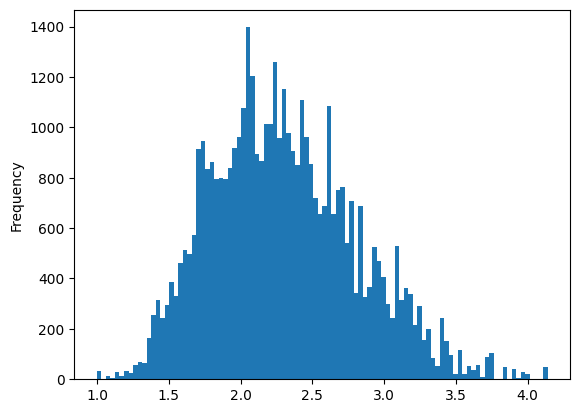

In [59]:
df["weight"].plot.hist(bins = 100)

In [60]:
train_df[(train_df["area_code"] == 13101) & (train_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
21,2007,2.271493e+06,0.393871,0.983720
371,2008,2.333333e+06,0.105263,0.022257
1950,2009,1.920000e+06,-0.154741,-0.316067
4640,2010,2.037037e+06,-0.126984,-0.215148
7218,2011,1.444444e+06,-0.247685,-0.672931
9298,2012,1.455556e+06,-0.285455,-0.658649
11073,2013,2.303030e+06,0.594406,1.149448
15673,2014,2.000000e+06,0.374046,0.689789
16241,2015,2.173913e+06,-0.056064,-0.243456
19221,2016,2.645833e+06,0.322917,0.263091


In [61]:
eval_df[(eval_df["area_code"] == 13101) & (eval_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
1511,2020,3.787942e+06,0.237409,0.186068
4758,2021,4.420875e+06,0.312098,0.326362
5839,2022,4.333333e+06,0.143981,0.108697


In [64]:
idx = 2983
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, asset_type, year = row["area_code"], row["asset_type"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["asset_type"] == asset_type)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window["time_diff"] = year - window["year"]
window

Target: -0.6231120505716249


,area_code,area,year,asset_type,unit_price_median_pct_chg,count_growth,yearly_price_growth,total_tax_growth,taxable_income_growth,taxable_income_per_taxpayer_growth,net_migration_ratio,new_dwellings_ratio,taxpayer_count_growth,unit_price_median,count,total_traded_area,in_migrations,out_migrations,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,total_tax,new_dwellings,existing_dwellings,unit_price_median_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,in_migrations_log_normalized_yearly,out_migrations_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_pct_chg_normalized_yearly,count_growth_normalized_yearly,yearly_price_growth_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,taxpayer_count_growth_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,metric_pct_chg_is_available,condo,land,log_population,weight,time_diff
22445,7461,Fukushima-ken Nishigo-mura,2015,building,0.290000,0.928571,0.105294,-0.024931,-0.003698,-0.016721,0.006205,0.0,0.013244,70370.370370,27.0,10260.0,900.0,774.0,20306.0,8645.0,23723105.0,2744.141700,3902270.0,0.0,0.0,0.271644,-0.346136,-0.159803,0.005059,-0.176064,-0.186294,-0.072544,-0.072806,-0.045612,0.181975,0.0,0.0,0.413387,2.191581,0.018678,-0.260069,-0.246315,-0.730352,1.257778,0.0,0.804376,1,1,0,1,1,0.0,0.0,4.307646,1.860178,6
26920,7461,Fukushima-ken Nishigo-mura,2016,building,-0.658548,-0.296296,-0.691076,-0.096412,0.034913,0.001323,0.002692,0.0,0.033545,21739.130435,19.0,10130.0,879.0,824.0,20432.0,8935.0,24551343.0,2747.772020,3526045.0,0.0,0.0,-0.871891,-0.620070,-0.162190,0.009841,-0.108980,-0.179517,-0.060224,-0.067085,-0.107029,0.111200,0.0,0.0,-1.086129,-0.932844,-1.567659,-3.427825,0.250672,-0.343480,0.705839,0.0,1.032671,1,1,0,1,1,0.0,0.0,4.310332,1.862864,5
27266,7461,Fukushima-ken Nishigo-mura,2017,building,-0.171053,0.105263,1.683333,0.055151,0.027318,0.008359,0.000879,0.0,0.018802,58333.333333,21.0,11635.0,848.0,830.0,20487.0,9103.0,25222046.0,2770.739976,3720509.0,0.0,0.0,0.077719,-0.548650,-0.041040,-0.004348,-0.100637,-0.175327,-0.053481,-0.060451,-0.103998,0.134794,0.0,0.0,-0.456220,0.117142,3.079044,1.544229,0.226407,-0.005182,0.507155,0.0,0.441964,1,1,0,1,1,0.0,0.0,4.311500,1.860327,4
32333,7461,Fukushima-ken Nishigo-mura,2018,building,1.967000,-0.047619,0.105714,0.048896,0.030369,0.013666,0.006974,0.0,0.016478,64500.000000,20.0,6850.0,965.0,822.0,20505.0,9253.0,25988022.0,2808.604993,3902426.0,0.0,0.0,0.177830,-0.580771,-0.522293,0.080245,-0.103282,-0.172145,-0.046322,-0.052155,-0.087450,0.160295,0.0,0.0,3.476127,-0.241816,-0.017066,1.571348,0.255676,0.038978,1.306624,0.0,0.545301,1,1,0,1,1,0.0,0.0,4.311881,1.860095,3
32647,7461,Fukushima-ken Nishigo-mura,2019,building,0.226551,0.100000,0.109284,0.095332,0.028248,0.002146,0.007749,0.0,0.026046,71548.821549,22.0,8225.0,890.0,730.0,20648.0,9494.0,26722130.0,2814.633453,4274452.0,0.0,0.0,0.286326,-0.480512,-0.322345,0.041520,-0.177802,-0.164938,-0.030775,-0.039732,-0.111725,0.928493,0.0,0.0,0.195973,0.164273,0.020778,2.251806,0.430941,-0.117335,1.397953,0.0,1.296012,1,1,0,1,1,0.0,0.0,4.314899,1.863113,2


In [65]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "yearly_price_growth",
    "count_growth",
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
    "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [66]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 27) (1,) [0.30864434] [2.52252897]
1 (1, 27) (1,) [-0.42022873] [3.16610295]
2 (1, 27) (1,) [-0.1705109] [3.07776002]
3 (1, 27) (1,) [3.44510914] [1.30508739]
0 torch.Size([5, 27]) torch.Size([1]) tensor([0.3086]) tensor([2.5225])
1 torch.Size([5, 27]) torch.Size([1]) tensor([-0.4202]) tensor([3.1661])
2 torch.Size([5, 27]) torch.Size([1]) tensor([-0.1705]) tensor([3.0778])
3 torch.Size([5, 27]) torch.Size([1]) tensor([3.4451]) tensor([1.3051])


In [67]:
BATCH_SIZE = 256

In [68]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# Building the Transformer Model

In [69]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [70]:
n_features = len(feature_columns)
d_hid = 64
nlayers = 2
dropout = 0

model = TimeSeriesLSTMModel(
    n_features=n_features,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [71]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 27]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.1939918994903564


In [72]:
learning_rate = 1e-2 # 3e-4
weight_decay = 1 # 1
num_epochs = 50

In [73]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [74]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 6.0185, Eval Loss: 6.4784
Train R^2: 0.2260, Eval R^2: 0.1489
Epoch: 1
Train Loss: 5.8216, Eval Loss: 6.5212
Train R^2: 0.2526, Eval R^2: 0.1406
Epoch: 2
Train Loss: 5.8079, Eval Loss: 6.6267
Train R^2: 0.2545, Eval R^2: 0.1277
Epoch: 3
Train Loss: 5.8208, Eval Loss: 6.6376
Train R^2: 0.2536, Eval R^2: 0.1258
Epoch: 4
Train Loss: 5.7644, Eval Loss: 6.4762
Train R^2: 0.2608, Eval R^2: 0.1477
Epoch: 5
Train Loss: 5.7486, Eval Loss: 6.5521
Train R^2: 0.2625, Eval R^2: 0.1370
Epoch: 6
Train Loss: 5.7360, Eval Loss: 6.4744
Train R^2: 0.2648, Eval R^2: 0.1485
Epoch: 7
Train Loss: 5.7286, Eval Loss: 6.3771
Train R^2: 0.2660, Eval R^2: 0.1618
Epoch: 8
Train Loss: 5.7390, Eval Loss: 6.4216
Train R^2: 0.2638, Eval R^2: 0.1542
Epoch: 9
Train Loss: 5.7099, Eval Loss: 6.2732
Train R^2: 0.2684, Eval R^2: 0.1754
Epoch: 10
Train Loss: 5.7099, Eval Loss: 6.2600
Train R^2: 0.2681, Eval R^2: 0.1752
Epoch: 11
Train Loss: 5.7032, Eval Loss: 6.2833
Train R^2: 0.2697, Eval R^2: 0.1731


KeyboardInterrupt: 

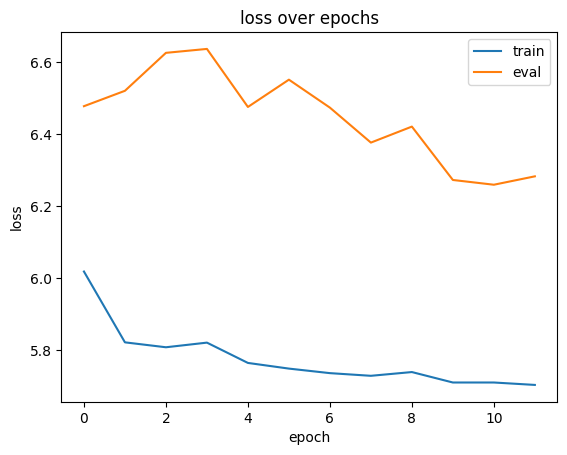

In [75]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

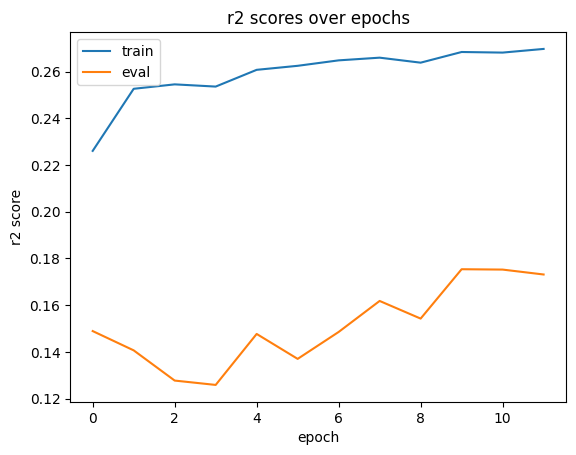

In [76]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [35]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 2.4709
Eval R2: 0.6796


In [36]:
def predict_return(model, area_code, year):
    area_df = df[(df["year"] == year) & (df["area_code"] == area_code)]

    area_dataset = JapanRETimeSeriesDataset(
        df,
        area_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    )

    area_dataloader = DataLoader(
        area_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    batch = next(iter(area_dataloader))
    
    model.eval()

    output = model(batch["window"].to(device), batch["mask"].to(device))
    return output.item()

In [37]:
years = [2020, 2021, 2022] # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_return(model, row["area_code"], row["year"]), axis=1
)
prediction_df = prediction_df.sort_values(
    by="year", ascending=False
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
18074,2022,27221,-1.298147,-0.313324,-1.323509
17324,2022,28212,-0.249031,-0.147399,-0.663334
17318,2022,15206,-0.854303,-0.233155,-1.004535
17319,2022,47348,1.672437,0.423042,1.606304
17320,2022,21361,-1.572772,-0.572982,-2.356621
...,...,...,...,...,...
15411,2020,24203,-0.396602,-0.157997,-1.050942
15410,2020,8214,-0.022239,-0.030913,-0.309195
15409,2020,27203,0.457672,0.166667,0.844006
15408,2020,14341,-0.595804,-0.160141,-1.063457


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

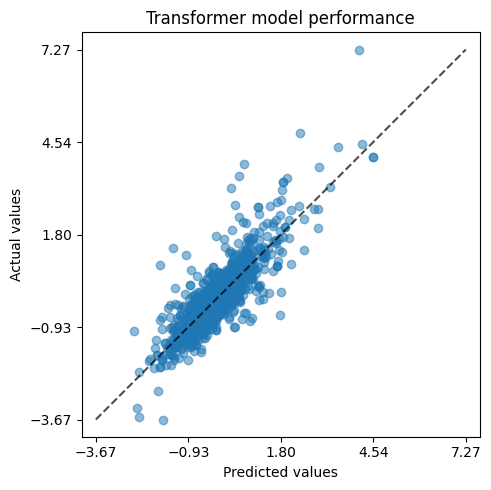

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

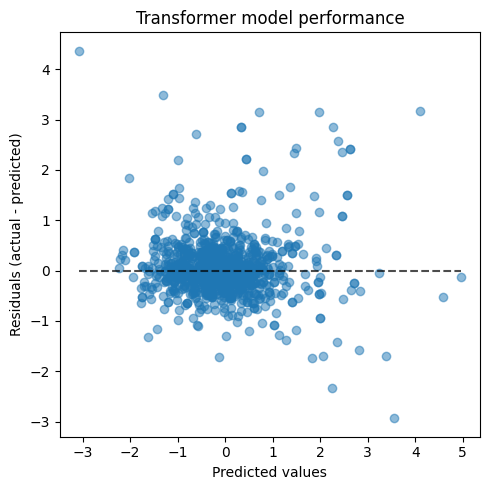

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()